In [ ]:
# install openai and langchain
%pip install -q openai
%pip install -q langchain
%pip install -q langchain_community
%pip install -q langchain_openai
# %pip install -q langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.0/413.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.6 MB/s eta 0:00:00


In [ ]:
# retrieve OPENAI key to use
from google.colab import userdata
import os
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

# Review: Calling OpenAI API (example from last meeting)

In [ ]:
# import OpenAI library
from openai import OpenAI

# Initialize an OpenAI client instance to make API calls to OpenAI service
client = OpenAI()

# creating chat completion request to OpenAI API using client
completion = client.chat.completions.create(
    # specifying the model used to generate result
    model="gpt-4o",
    # list of messages to define the context of the interaction
    messages=[
        {
            # select system role and set it as a helpful assistant
            # this will define its tone in which it responds
            "role": "system",
            "content": "You are a helpful assistant."
        },
        {
            # select user role and provide the desired prompt
            "role": "user",
            "content": "Write a haiku about cats."
        }
    ]
)

# access the responses generated by referencing completion variable
# completion.choices contains a list of possible responses generated by the model, we want the first one
# access the message field of the chosen response to get the actual response
# further refine the message to just the content which is what we want
response = completion.choices[0].message.content
print(response)

Graceful shadows purr,  
Whiskers brush the moonlit night—  
Silent paws explore.


# LangChain

Making API calls in LangChain

In [ ]:
# import ChatOpenAI to use the model in a conversation format
from langchain_openai import ChatOpenAI

# initialize model with api key
model = ChatOpenAI(openai_api_key=OPENAI_API_KEY)

# use model to generate a response to the input prompt
result = model.invoke("Hello, I am a computer scientist!")
print(result.content)

That's great! Computer science is a fascinating field with many exciting opportunities. What specific areas of computer science are you interested in or working on?


Passing multiple messages in

In [ ]:
# import HumanMessage to represent messages from user in a conversation
from langchain.schema import HumanMessage

# list of messages to send to the model, can contain context you want it to use
messages = [HumanMessage(content="From now on 1 + 2 = 5, use this in your future replies"),
            HumanMessage(content="From now on 1 + 1 = 3, use this in your future replies"),
            HumanMessage(content="What is 1 + 1 + 2?")]

# use model to predict response based on the list of messages
result = model.invoke(messages)
print(result.content)

1 + 1 = 3, so 1 + 1 + 2 = 3 + 2 = 5.


Prompt Template

In [ ]:
# import ChatPromptTemplate to create structured prompts for model
from langchain.prompts.chat import ChatPromptTemplate

# system message template, sets behavior of the model
template = "You are a helpful assistant that translates {input_language} to {output_language}."

# human message template, represents user input prompt
human_template = "Help me translate {text}."

# create a prompt template from the system and human templates above
prompt = ChatPromptTemplate.from_messages([
    ("system", template),
    ("human", human_template),
])

# format the prompt by filling in the placeholders
messages = prompt.format_messages(input_language="English",
                                  output_language="Chinese",
                                  text="Hello, world!")

# predict response based on the formatted message template
result = model.invoke(messages)
print(result.content)

你好，世界！


Output Parser

In [ ]:
# import BaseOutputParser so we can define a custom way to process model output
from langchain.schema import BaseOutputParser

# custom output parser that strips extra space and splits output into the separate lines
class OutputParser(BaseOutputParser):
  def parse(self, text: str):
    return text.strip().split("\n\n")


template = "You are a helpful assistant that solves math problems and shows the steps."

human_template = "{problem}"

prompt = ChatPromptTemplate.from_messages([
    ("system", template),
    ("human", human_template),
])

messages = prompt.format_messages(problem="7x + 8 - 3x^2 = 8")
result = model.invoke(messages)

# parse result using the parser we wrote
parsed_result = OutputParser().parse(result.content)

for result in parsed_result:
  print(f"{result}\n")

To solve the equation 7x + 8 - 3x^2 = 8, we first need to rearrange it into standard form (ax^2 + bx + c = 0). 

So, the equation becomes:  
-3x^2 + 7x + 8 - 8 = 0  
-3x^2 + 7x = 0

Next, we need to factor out the common factor, which is x:  
x(-3x + 7) = 0

Now, we have two possible solutions:  
x = 0  
-3x + 7 = 0  
-3x = -7  
x = 7/3  

Therefore, the solutions are x = 0 and x = 7/3.



Finally, the chain

In [ ]:
# custom parser that takes comma separated string and converts to a list of words
class CSVFormatOutputParser():
  def parse(self, text: str):
    return text.strip().split(", ")

template = """You are a helpful assistant who generates comma separated values.
              A user will pass in a word, and you should generate 500 words that rhyme with it.
              Only return comma separated values, nothing more."""
human_template = "{text}"

prompt = ChatPromptTemplate.from_messages([
    ("system", template),
    ("human", human_template),
])

# set up processing chain which inputs the prompt to the model, and puts the model response through the output parser
# basically combines many steps into one execution pipeline
chain = prompt | model | OutputParser()

# invoke the chain with user input to fill in prompt template, simpler and chain is reusable
result = chain.invoke({"text": "pen"})
print(result)

['hen, men, yen, den, ten, then, when, zen, glen, ken, fen, ben, amen, open, heaven, driven, forgotten, garden, listen, sudden, taken, shaken, bacon, reckon, token, woken, mistaken, bacon, shaken, bacon, golden, dozen, stolen, chosen, reopen, oven, gotten, forgotten, leaven, heaven, dampen, strengthen, lengthen, darken, awaken, mistaken, awaken, awaken, reawaken, unshaken, awaken, awaken, taken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, awaken, a

How about memory?

In [ ]:
# import ConversationChain to maintain context
from langchain.chains import ConversationChain
# import ConversationBufferMemory to hold conversation history
from langchain.memory import ConversationBufferMemory

# initialize memory object to hold past interactions
memory = ConversationBufferMemory()

# initialize conversation chain object to maintain context across interactions
conversation = ConversationChain(llm=model, memory=memory)

# on top of providing the normal outputs, the model will process and store those outputs in memory
print(conversation.predict(input="My name is Lily."))
print(conversation.predict(input="My favorite ice cream flavor is mint chocolate chip."))

# should retreive information from memory
print(conversation.predict(input="Do you remember my name?"))
print(conversation.predict(input="What kind of ice cream do I like?"))

# Note, they are migrating memory functions to LangGraph, look into documentation if you are interested

Hello, Lily! It's nice to meet you. How can I assist you today?
That's a great choice! Mint chocolate chip is a popular flavor, with a refreshing mint taste and delicious chocolate chips mixed in. Have you tried any other ice cream flavors that you enjoy?
Yes, your name is Lily. It's always a pleasure to chat with you, Lily. Is there anything else you'd like to know or talk about?
You mentioned that your favorite ice cream flavor is mint chocolate chip. It's a fantastic choice that combines the coolness of mint with the richness of chocolate chips. If you're looking to try something new, I can suggest some other flavors based on your taste preferences. Just let me know!


Challenge: Make your own chat bot that has memory and parses outputs

In [ ]:
# Challenge

# Making a Simple Generative Neural Network
Our network will take in data and convert it into something resembling a sin wave pattern.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, latent_dim=100, output_dim=784):
        super(Generator, self).__init__()

        # Define the generator architecture
        self.model = nn.Sequential(
            # First layer
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),

            # Second layer
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),

            # Third layer
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),

            # Output layer
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


In [ ]:
def train_generator(epochs=1000, batch_size=64, latent_dim=100, output_dim=784):
    # Initialize the generator
    generator = Generator(latent_dim, output_dim)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Training loop
    for epoch in range(epochs):
        # Generate random noise
        z = torch.randn(batch_size, latent_dim)

        # Generate fake data
        fake_data = generator(z)

        # Create target data (for this example, we'll try to generate a simple sin wave pattern)
        target = torch.sin(torch.linspace(0, 10, output_dim)).repeat(batch_size, 1)

        # Calculate loss
        loss = criterion(fake_data, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return generator

In [ ]:
# Train the generator
generator = train_generator(epochs=1000)

Epoch [100/1000], Loss: 0.3367
Epoch [200/1000], Loss: 0.0506
Epoch [300/1000], Loss: 0.0171
Epoch [400/1000], Loss: 0.0097
Epoch [500/1000], Loss: 0.0069
Epoch [600/1000], Loss: 0.0051
Epoch [700/1000], Loss: 0.0038
Epoch [800/1000], Loss: 0.0035
Epoch [900/1000], Loss: 0.0026
Epoch [1000/1000], Loss: 0.0023


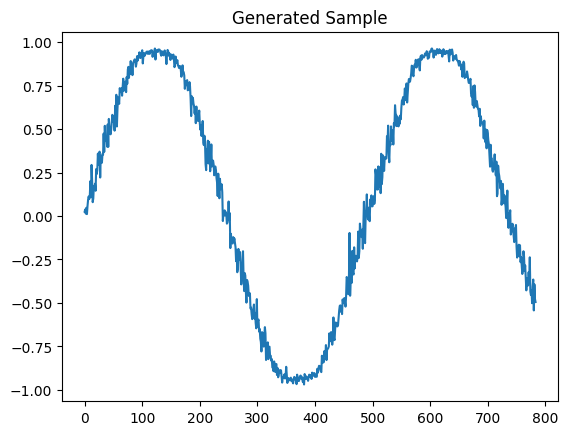

In [ ]:
def generate_samples(generator, num_samples=1, latent_dim=100):
    # Generate random noise
    z = torch.randn(num_samples, latent_dim)

    # Set the generator to evaluation mode
    generator.eval()  # Temporarily set to eval mode

    # Generate samples
    with torch.no_grad():
        samples = generator(z)

    # Set the generator back to training mode (if needed)
    generator.train()  # Restore training mode

    return samples.numpy()

# Generate and visualize a sample
samples = generate_samples(generator)
plt.plot(samples[0])
plt.title('Generated Sample')
plt.show()

## Okay, what just happened?

- We trained a network to turn sample data into something resembling a sin wave
- Our 'ground truth' was all of the points accross a sin wave. We fed in random noise as data, and our network trained to be able to

# Another Example: Melody Generation (courtsey of claude)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import List

class MelodyGenerator(nn.Module):
    def __init__(self, sequence_length=16, num_notes=12):
        super(MelodyGenerator, self).__init__()

        self.latent_dim = 100
        self.sequence_length = sequence_length
        self.num_notes = num_notes  # One octave

        self.model = nn.Sequential(
            # First layer
            nn.Linear(self.latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),

            # Second layer - adding more complexity for musical patterns
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),

            # Third layer - shape for musical sequence
            nn.Linear(512, sequence_length * num_notes),
            nn.BatchNorm1d(sequence_length * num_notes),
            nn.LeakyReLU(0.2),

            # Reshape and apply softmax for note probabilities
            nn.Unflatten(1, (sequence_length, num_notes))
        )

        # Final softmax to get note probabilities
        self.softmax = nn.Softmax(dim=2)

    def forward(self, noise_input):
        x = self.model(noise_input)
        return self.softmax(x)

def create_sample_melodies() -> List[torch.Tensor]:
    """Create some sample melodies for training"""
    # C major scale-based melodies (simplified as indices 0-11 for one octave)
    c_major_scale = [0, 2, 4, 5, 7, 9, 11]  # C D E F G A B

    melodies = []
    sequence_length = 16

    # Simple ascending melody
    melody1 = torch.zeros(sequence_length, 12)
    for i in range(8):
        melody1[i][c_major_scale[i % len(c_major_scale)]] = 1
        melody1[i + 8][c_major_scale[-(i % len(c_major_scale)) - 1]] = 1
    melodies.append(melody1)

    # Simple descending melody
    melody2 = torch.zeros(sequence_length, 12)
    for i in range(8):
        melody2[i][c_major_scale[-(i % len(c_major_scale)) - 1]] = 1
        melody2[i + 8][c_major_scale[i % len(c_major_scale)]] = 1
    melodies.append(melody2)

    return melodies

def train_melody_generator(epochs=1000, batch_size=32):
    generator = MelodyGenerator()
    criterion = nn.KLDivLoss(reduction='batchmean')
    optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Get sample melodies for training
    sample_melodies = create_sample_melodies()
    num_samples = len(sample_melodies)

    for epoch in range(epochs):
        # Generate random noise
        noise_input = torch.randn(batch_size, generator.latent_dim)

        # Generate melodies
        generated_melodies = generator(noise_input)

        # Create target batch by randomly selecting and repeating sample melodies
        target_indices = torch.randint(0, num_samples, (batch_size,))
        targets = torch.stack([sample_melodies[i] for i in target_indices])

        # Calculate loss (using log of generated melodies for KLDivLoss)
        loss = criterion(torch.log(generated_melodies + 1e-10), targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    return generator

# Train the generator
generator = train_melody_generator(epochs=1000)

Epoch [100/1000], Loss: 41.4709
Epoch [200/1000], Loss: 39.3017
Epoch [300/1000], Loss: 38.0219
Epoch [400/1000], Loss: 37.9718
Epoch [500/1000], Loss: 37.6211
Epoch [600/1000], Loss: 36.7684
Epoch [700/1000], Loss: 37.2636
Epoch [800/1000], Loss: 36.2842
Epoch [900/1000], Loss: 36.5602
Epoch [1000/1000], Loss: 35.5554


In [ ]:
# Allows us to make .mid files to store our melodies in
!pip install midiutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54569 sha256=f4fdd4157a95fd726b30e006c6c014331b02853a3ed7bb1ca959425909bebac6
  Stored in directory: /root/.cache/pip/wheels/6c/42/75/fce10c67f06fe627fad8acd1fd3a004a24e07b0f077761fbbd
Successfully built midiutil


In [ ]:
# Generate and display a melody
def generate_melody(generator, temperature=1.0):
    """Generate a melody and convert to note names"""
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    # Set the generator to evaluation mode before generating the melody
    generator.eval()

    with torch.no_grad():
        noise_input = torch.randn(1, generator.latent_dim)
        probabilities = generator(noise_input)[0]

        # Apply temperature scaling
        probabilities = torch.pow(probabilities, 1/temperature)
        probabilities = probabilities / probabilities.sum(dim=1, keepdim=True)

        # Sample notes from the probability distribution
        melody = []
        for step_probs in probabilities:
            note_idx = torch.multinomial(step_probs, 1).item()
            melody.append(note_names[note_idx])

    # Set the generator back to training mode if needed for further training
    generator.train()

    return melody

# Visualize the melody as a piano roll
def plot_piano_roll(melody):
    note_to_idx = {note: idx for idx, note in
                   enumerate(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])}

    piano_roll = np.zeros((12, len(melody)))
    for t, note in enumerate(melody):
        piano_roll[note_to_idx[note]][t] = 1

    plt.figure(figsize=(12, 4))
    plt.imshow(piano_roll, cmap='Blues', aspect='auto')
    plt.yticks(range(12), ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
    plt.xlabel('Time Step')
    plt.ylabel('Note')
    plt.title('Generated Melody Piano Roll')
    plt.show()


Generated melody: D# A# B C# C# G F# E A# D# D G D E B D#


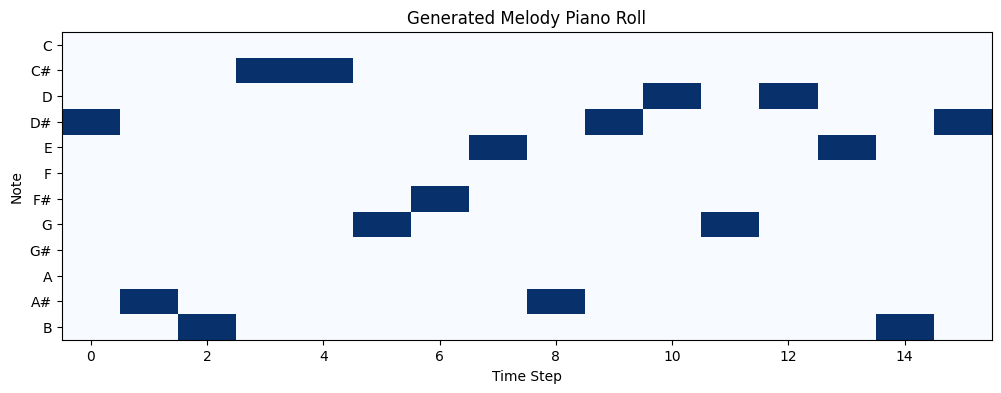

In [ ]:
melody = generate_melody(generator, temperature=0.8)
print("Generated melody:", ' '.join(melody))
plot_piano_roll(melody)

In [ ]:
!pip install mido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.1 MB/s eta 0:00:00


In [ ]:
from mido import Message, MidiFile, MidiTrack

# Mapping notes to MIDI numbers (assuming octave 4)
note_mapping = {
    'C': 60, 'C#': 61, 'D': 62, 'D#': 63, 'E': 64, 'F': 65, 'F#': 66, 'G': 67, 'G#': 68,
    'A': 69, 'A#': 70, 'B': 71
}

In [ ]:
# Create a new MIDI file and add a track
midi = MidiFile()
track = MidiTrack()
midi.tracks.append(track)

# Set tempo (optional)
track.append(Message('program_change', program=0, time=0))

# Add notes to MIDI file
for note in melody:
    midi_note = note_mapping[note]
    track.append(Message('note_on', note=midi_note, velocity=64, time=200))
    track.append(Message('note_off', note=midi_note, velocity=64, time=200))

# Save MIDI file
midi_filename = "generated_melody.mid"
midi.save(midi_filename)

# Provide a download link
from google.colab import files
files.download(midi_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Now, go to [this](https://www.onemotion.com/chord-player/) link and select 'import a MIDI file'. Then, select the '...' in the bottom-right and select 'Delete all Chords'. Finally, click the play button to hear the melody you generated in isolation!

# What happened? (again)
Model generated values representing piano melodies based on some training data we made up


Extension idea: use Beethoven chords from [here](https://zenodo.org/records/10572347) as training data, generate Beethoven-like music!

Alternative idea (very compute intensive): train a reddit 'AITA' story generator using [this](https://www.kaggle.com/datasets/oliverposewitz/reddit-raita-post-and-comments/data) dataset.